# Classification of key based on chords

The task is to classify each chord segment with a key.

## Inputs  & outputs

Each data point represents a chord segment.

Inputs are chord segments with duration and a set of binary pitch classes contained in the chord. Thus the input dimension is 1+12 = 13.

Output of each data point is the key within the segment represented by its canonical diatonic key root pitch class. So there are 12 possible class values. With one-hot encoding the output dimension is 12.


## Assumptions

- assumptions to simplify the problem:
  - we assume that each segments has just a single chord and key
  - we ignore chord segments with no chord (`N`) or no key (silence)
  - we represent the key with its canonical diatonic key root pitch class
    - ie. no distinction of modes (major, minor, dorian, etc.) or accidentals (sharp, flat)
  - the inputs should be selected such that each input spans a single key, not multiple ones

## The strategy of tasks - from simpler to harder 

First we can try to classify each chord segment independently to establish a baseline performance. In practice this is not too realistic, since the key may be distinguisehd by a set of multiple chords.

Then we can try to use as inputs short sequences of adjacent chord segments of fixed size. This might be more realistic and be usable for non-recurrent ML models.

Ideally we should handle the fact that the sequence of chords is of a variable length and use recurrent models and not be constrained by a fixed window.


## ML algorithms

As for the ML models we should start with a plain multi-class logistic regression.

Then we could try deep neural networks:
- architecture:
  - input layer: 13
  - hidden layer(s): ???
  - output layer: 12
    - soft-max classifer
  - regularization - dropout, ...
- pre-training with an autoencoder, then fine tuning with labels
- experiment with:
  - convolution layers (http://theanets.readthedocs.org/en/stable/reference.html#module-theanets.layers.convolution)
    - eg. we would like to capture several distance metrics on the pitch class space:
      - skip by 1 (plain pitch class neighborhood), skip by 7 (circle-of-fifths similarity)
    - for pitch spaces we could also use skip by 12 (octave similarity)
  - recurrent layers (http://theanets.readthedocs.org/en/stable/reference.html#module-theanets.layers.recurrent)
    - we could use the Predict output layer

## Evaluation

TODO

In [10]:
%pylab inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import glob

pylab.rcParams['figure.figsize'] = (16, 12)

Populating the interactive namespace from numpy and matplotlib


In [11]:
dataset = pd.read_csv('data/beatles/derived/all_chords_with_keys.tsv', sep='\t')
dataset

,track_id,start,end,duration,label,root,bass,C,Db,D,...,E,F,Gb,G,Ab,A,Bb,B,key_diatonic_root_label,key_diatonic_root
0,0,0.000000,2.612267,2.612267,N,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
1,0,2.612267,11.459070,8.846803,E,4,4,0,0,0,...,1,0,0,0,1,0,0,1,E,4
2,0,11.459070,12.921927,1.462857,A,9,9,0,1,0,...,1,0,0,0,0,1,0,0,E,4
3,0,12.921927,17.443474,4.521547,E,4,4,0,0,0,...,1,0,0,0,1,0,0,1,E,4
4,0,17.443474,20.410362,2.966888,B,11,11,0,0,0,...,0,0,1,0,0,0,0,1,E,4
5,0,20.410362,21.908049,1.497687,E,4,4,0,0,0,...,1,0,0,0,1,0,0,1,E,4
6,0,21.908049,23.370907,1.462858,E:7/3,4,8,0,0,1,...,1,0,0,0,1,0,0,1,E,4
7,0,23.370907,24.856984,1.486077,A,9,9,0,1,0,...,1,0,0,0,0,1,0,0,E,4
8,0,24.856984,26.343061,1.486077,A:min/b3,9,0,1,0,0,...,1,0,0,0,0,1,0,0,E,4
9,0,26.343061,27.840748,1.497687,E,4,4,0,0,0,...,1,0,0,0,1,0,0,1,E,4


## Simple silly classification of each segment alone

In [239]:
dataset = dataset.dropna()

pcs_columns = ['C','Db','D','Eb','E','F','Gb','G','Ab','A','Bb','B']
# note: we could also try use features like 'root' or 'bass'
input_cols = pcs_columns
output_col = 'key_diatonic_root'

def select_X_y(df):
    X = df[input_cols].astype(np.int32)
    y = df[output_col].astype(np.int32)
    return X, y

X, y = select_X_y(dataset)

In [197]:
len(dataset)

14441

In [198]:
X.head()

,C,Db,D,Eb,E,F,Gb,G,Ab,A,Bb,B
1,0,0,0,0,1,0,0,0,1,0,0,1
2,0,1,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,1,0,0,1
4,0,0,0,1,0,0,1,0,0,0,0,1
5,0,0,0,0,1,0,0,0,1,0,0,1


In [199]:
y.head()

,key_diatonic_root
1,4
2,4
3,4
4,4
5,4


In [200]:
from sklearn.cross_validation import train_test_split

def split_dataset(X, y, test_percentage=0.2, valid_percentage=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percentage, random_state=random_state)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_percentage/(1-test_percentage), random_state=random_state)
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

((X_train, y_train), (X_valid, y_valid), (X_test, y_test)) = split_dataset(X, y)

[d.shape for d in (X_train, y_train, X_valid, y_valid, X_test, y_test)]

[(8664, 12), (8664, 1), (2888, 12), (2888, 1), (2889, 12), (2889, 1)]

In [201]:
from sklearn.linear_model import LogisticRegression

In [202]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [227]:
from sklearn.metrics import classification_report, confusion_matrix

def accuracy_report(model, X_train, y_train, X_valid, y_valid):
    # mean accuracy on the given test data and labels
    accuracy_train, accuracy_valid = model.score(X_train, y_train), model.score(X_valid, y_valid)
    print('training set accuracy (%):', accuracy_train)
    print('validation set accuracy (%):', accuracy_valid)
    print('difference (% points):', accuracy_train - accuracy_valid)

accuracy_report(lr_model, X_train, y_train, X_valid, y_valid)

training set accuracy (%): 0.428208679594
validation set accuracy (%): 0.423476454294
difference (% points): 0.00473222530009


In [208]:
random_batches = 100
y_random_uniform = np.random.random_integers(low=0, high=11, size=(len(X_valid), random_batches))
y_pred_lr_valid = lr_model.predict(X_valid)

In [209]:
def prior_class_probabilities(y):
    priors = pd.Series(np.zeros(12))
    hist = (pd.Series(y.ravel()).value_counts() / len(y))
    priors[hist.index] = hist
    return priors

priors_valid = prior_class_probabilities(y_valid)
priors_valid

0     0.153393
1     0.005194
2     0.135042
3     0.029778
4     0.145776
5     0.066136
6     0.016620
7     0.200485
8     0.013850
9     0.176939
10    0.016620
11    0.040166
dtype: float64

In [211]:
# random samples of classes based on prior probabilities of each class
y_random_prior = numpy.random.choice(np.arange(12), size=(len(y_valid), random_batches), p=priors_valid)
pd.Series(y_random_prior[0]).value_counts() / len(y_random_prior)

0    0.008310
7    0.006925
2    0.005194
9    0.004155
4    0.003463
5    0.002770
3    0.002770
8    0.000693
1    0.000346
dtype: float64

In [218]:
mean_random_uniform_accuracy = ((y_random_uniform == np.outer(np.ones(y_random_uniform.shape[1]), y_valid).T).sum(axis=0) / len(X_valid)).mean() * 100
print('validation set, mean accuracy of uniform random guess (%):', mean_random_uniform_accuracy)
mean_random_prior_accuracy = ((y_random_prior == np.outer(np.ones(y_random_prior.shape[1]), y_valid).T).sum(axis=0) / len(X_valid)).mean() * 100
print('validation set, mean accuracy of random guess with prior class probabilities (%):', mean_random_prior_accuracy)

lr_accuracy = sum(y_pred_lr_valid == y_valid.ravel()) / len(X_valid) * 100
print('validation set, accuracy of LR model (%):', lr_accuracy)

print('the model is better than uniform random guess', lr_accuracy / mean_random_uniform_accuracy, 'times')
print('the model is better than prior random guess', lr_accuracy / mean_random_prior_accuracy, 'times')

validation set, mean accuracy of uniform random guess (%): 8.36842105263
validation set, mean accuracy of random guess with prior class probabilities (%): 14.1371191136
validation set, accuracy of LR model (%): 42.3476454294
the model is better than uniform random guess 5.06041046011 times
the model is better than prior random guess 2.99549328892 times


We can see that the seemingly good performance of the simple model is caused by the model trained on the skewed class prior probabilities. When we compare the model to random guessing based on the priors, the model is just 3x better than this kind of random guessing.

In [219]:
print(classification_report(y_pred_lr_valid, y_valid))

             precision    recall  f1-score   support

          0       0.57      0.47      0.52       535
          1       0.00      0.00      0.00         0
          2       0.37      0.34      0.36       427
          3       0.45      0.34      0.39       114
          4       0.55      0.47      0.50       491
          5       0.29      0.42      0.34       130
          6       0.44      0.39      0.41        54
          7       0.42      0.46      0.44       532
          8       0.25      0.26      0.25        39
          9       0.41      0.41      0.41       507
         10       0.25      0.29      0.27        41
         11       0.03      0.22      0.06        18

avg / total       0.45      0.42      0.43      2888



/Users/bzamecnik/Documents/dev/pyvenv/py3.4/lib/python3.4/site-packages/sklearn/metrics/metrics.py:1773: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Notes

- an accuracy of pure guess should be theoretically 1/12 ~= 8.333 %, a few rounds of random samples give a very close number
- even with this simple ML method and context of a single chord the accuracy both both sets is not to bad (~ 5x better than random guess)
- the training accuracy is just slightly better than the validation one
  - it means the model is very biased and is not overfitted, more data would likely not help
- the classes are very skewed, so we could generate synthetic data points in order to make classes uniform

Let's look at the actual results of classification on the validation set.

In [122]:
def classification_results(X, y_true, y_pred):
    return pd.DataFrame(
        np.hstack([X, y_true.reshape(-1, 1), y_pred.reshape(-1, 1)]),
        columns=input_cols+['label_true']+['label_pred'])

classification_valid = classification_results(X_valid, y_valid, y_pred_lr_valid)
classification_valid

(2888, 12) (2888, 1) (2888,)


,C,Db,D,Eb,E,F,Gb,G,Ab,A,Bb,B,label_true,label_pred
0,0,0,0,0,1,0,0,1,0,0,0,1,4,7
1,0,1,0,0,1,0,0,0,0,1,0,0,9,9
2,0,0,0,0,1,0,0,0,1,0,0,1,7,4
3,0,0,0,1,0,0,1,0,0,0,0,1,4,4
4,0,1,0,0,1,0,1,0,0,1,0,0,4,4
5,1,0,0,0,1,0,0,0,0,1,0,0,7,0
6,0,1,0,0,0,1,0,0,1,0,0,0,8,8
7,0,0,1,0,0,0,0,1,0,0,0,1,7,7
8,1,0,0,0,1,0,0,0,0,1,0,0,7,0
9,0,0,0,0,1,0,0,0,1,0,0,1,4,4


In [39]:
classification_valid['is_correct'] = classification_valid['label_true'] == classification_valid['label_pred']

print('accuracy on validation set (%)', sum(classification_valid['is_correct']) / len(classification_valid) * 100)

accuracy on validation set (%) 42.3476454294


The `score()` from the `LogisticRegression` model seems to really corresponds to manually computed accuracy.

In [263]:
def key_classification_error_report(classification):
    errors = ((classification['label_true'] - classification['label_pred']) + 12) % 12
    errors_hist = errors.value_counts()
    stem(errors_hist / len(errors) * 100)
    gca().set_xticks(np.arange(len(errors_hist)))
    gca().set_xticklabels(errors_hist.index)
    xlabel('error (true - predicted key pitch class)')
    ylabel('%')
    return errors, errors_hist

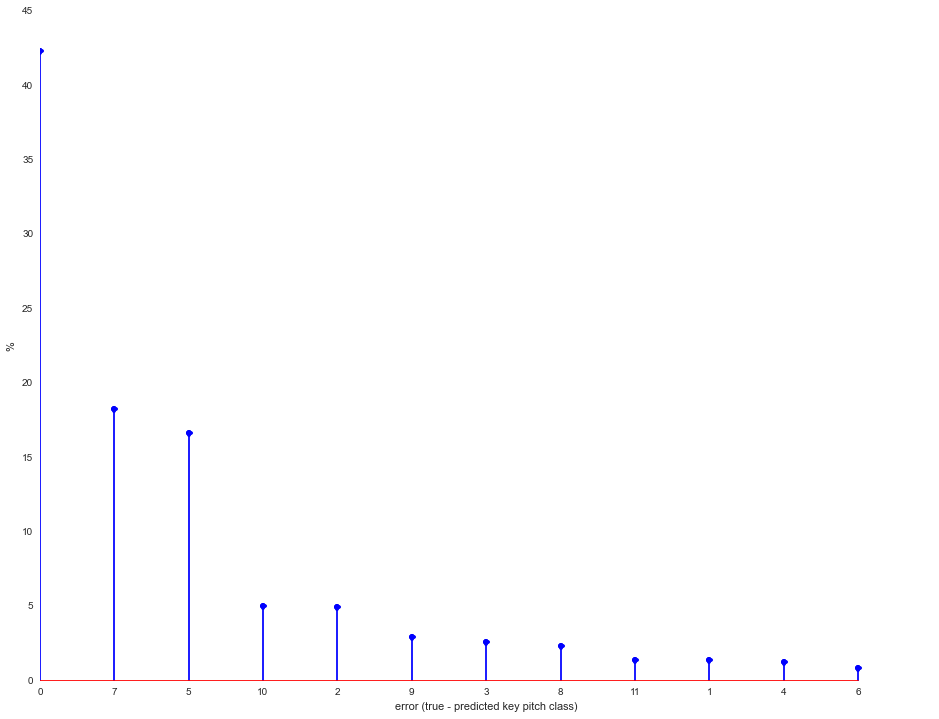

In [264]:
key_classification_error_report(classification_valid);

### Synthetic data - all transpositions of the original dataset

This dataset show have all classes with uniform prior probabilities.

It is expected that the model would perform worse since it cannot overfit on the priors.

In [248]:
dataset_synth = pd.read_csv('data/beatles/derived/all_chords_with_keys_synth.tsv', sep='\t')

In [249]:
dataset_synth = dataset_synth.dropna()
X, y = select_X_y(dataset_synth)

In [250]:
len(dataset_synth), len(X), len(y)

(173292, 173292, 173292)

In [251]:
((X_train, y_train), (X_valid, y_valid), (X_test, y_test)) = split_dataset(X, y)

In [253]:
lr_model_synth = LogisticRegression()
lr_model_synth.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [254]:
accuracy_report(lr_model_synth, X_train, y_train, X_valid, y_valid)
lr_synth_accuracy = 100 * lr_model_synth.score(X_valid, y_valid)
print('accuracy of model without synth data', lr_accuracy)
print('the model is better than uniform random guess', lr_synth_accuracy / mean_random_uniform_accuracy, 'times')

training set accuracy (%): 0.381585781061
validation set accuracy (%): 0.379122305895
difference (% points): 0.00246347516608
accuracy of model withou synth data 42.3476454294
the model is better than uniform random guess 4.53039233459 times


We can se the model is worse than model trained on data with skewed classes but not dramatically.

In [266]:
y_pred_lr_synth_valid = lr_model_synth.predict(X_valid)

(34659, 12) (34659,) (34659,)


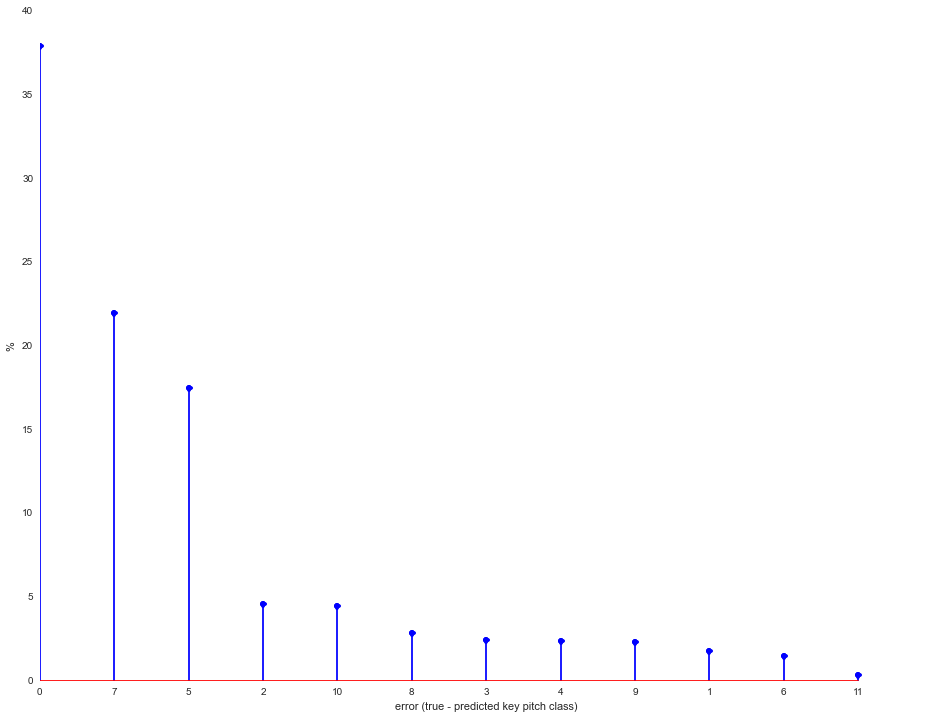

In [267]:
key_classification_error_report(classification_results(X_valid, y_valid, y_pred_lr_synth_valid));

Since there's almost no gap between training and validation accuracy the model seems to be highly biased, just too simple. We can try a few combinations of regularization parameters, but we expect regularization do not help here.

As for the kind of errors, we can see the correct key is often quite close to the true key on the circle of fifths. Moreover, the distribution of errors nicely follows the two-way distance on the circle of fifths. This is an important thing and should be taken into account when choosing/designing the cost function or validation metric.

In [259]:
from sklearn.grid_search import GridSearchCV

def tune_lr_model_on_grid():
    model = LogisticRegression()
    grid = GridSearchCV(estimator=model, param_grid=dict(C=[0.1, 0.5, 1], penalty=['l2', 'l1']))
    # let the CV do multiple train-valid splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    grid.fit(X_train, y_train)
    return grid

lr_model_synth_grid = tune_lr_model_on_grid()
print(lr_model_synth_grid)
print('best mean accuracy:', lr_model_synth_grid.best_score_)
print(lr_model_synth_grid.best_estimator_.C, lr_model_synth_grid.best_estimator_.penalty)
print(lr_model_synth_grid.grid_scores_)

GridSearchCV(cv=None,
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': [0.1, 0.5, 1], 'penalty': ['l2', 'l1']},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)
0.380508248397
1
GridSearchCV(cv=None,
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': [0.1, 0.5, 1], 'penalty': ['l2', 'l1']},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)
best mean accuracy: 0.380508248397
1 l2
[mean: 0.38034, std: 0.00161, params: {'C': 0.1, 'penalty': 'l2'}, mean: 0.38041, std: 0.00153, params: {'C': 0.1, 'penalty':

As we can see regularization didn't help.

# TODO - next steps

- prepare chord blocks
  - put several adjacent chords within a single key into each data point
  - chord block are expected to carry enough information to enable more reasonable key classification
  - use the synthetic unskewed data
- try the same model training on the chord block data
  - LogisticRegression with cross-validated grid search
  - try some tree-based model
  - try deep neural networks